# WellSide Pressure Prediction

Importing required libraries

In [129]:
import numpy as np
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Importing data

Reading the data file in pandas data frame and printing head of the data.

In [2]:
file='Attachment_1662806747.xlsx'
df=pd.read_excel(file)
df.head()

,Well_Name,Well_Stage,Time,Discharge_Rate_ADC1,prop_rate,Perc_Well,Perc_Stage,inline_prop_conc,UB_Isopach,MB_Isopach,...,perf_shot_top_depth_MD,perf_phasing,perf_shot_density,perf_shot_plan,perf_SZHOLEACT,perf_SZHOLENOM,casing_DEPTHBTMCALC,casing_DEPTHTOPCALC,casing_SZODNOM,Wellside_Pressure
0,W1,1,7,28.469387,0.000000,0.032258,0.001690,0.000000,17.482805,43.333515,...,20822.0,120.0,3.0,3.0,0.38,3.419939,21155.0,10155.3,4.5,7993.431641
1,W1,1,107,34.991882,0.123095,0.032258,0.025827,0.005025,17.482805,43.333515,...,20822.0,120.0,3.0,3.0,0.38,3.419939,21155.0,10155.3,4.5,8231.067383
2,W1,1,207,41.274349,0.048407,0.032258,0.049964,0.001675,17.482805,43.333515,...,20822.0,120.0,3.0,3.0,0.38,3.419939,21155.0,10155.3,4.5,8175.221191
3,W1,1,307,43.956402,13.609436,0.032258,0.074101,0.442289,17.482805,43.333515,...,20822.0,120.0,3.0,3.0,0.38,3.419939,21155.0,10155.3,4.5,8386.425781
4,W1,1,407,44.947819,0.000000,0.032258,0.098238,0.000000,17.482805,43.333515,...,20822.0,120.0,3.0,3.0,0.38,3.419939,21155.0,10155.3,4.5,8396.589844


## EDA

Let's look at the shape of the data

In [3]:
df.shape

(5863, 35)

This seems that there are 5868 rows and 35 columns.

Take a look at the info of the data and features

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5863 entries, 0 to 5862
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Well_Name                  5863 non-null   object 
 1   Well_Stage                 5863 non-null   int64  
 2   Time                       5863 non-null   int64  
 3   Discharge_Rate_ADC1        5863 non-null   float64
 4   prop_rate                  5863 non-null   float64
 5   Perc_Well                  5863 non-null   float64
 6   Perc_Stage                 5863 non-null   float64
 7   inline_prop_conc           5863 non-null   float64
 8   UB_Isopach                 5863 non-null   float64
 9   MB_Isopach                 5863 non-null   float64
 10  LB_Isopach                 5863 non-null   float64
 11  Sanish_Isopach             5863 non-null   float64
 12  Basal_Bakken_Isopach       5863 non-null   float64
 13  TF1_reservoir_Isopach      5863 non-null   float

Data seems to have no null values which is good and there is only one feature with data type object.

Some basic statistics insights

In [5]:
df.describe()

,Well_Stage,Time,Discharge_Rate_ADC1,prop_rate,Perc_Well,Perc_Stage,inline_prop_conc,UB_Isopach,MB_Isopach,LB_Isopach,...,perf_shot_top_depth_MD,perf_phasing,perf_shot_density,perf_shot_plan,perf_SZHOLEACT,perf_SZHOLENOM,casing_DEPTHBTMCALC,casing_DEPTHTOPCALC,casing_SZODNOM,Wellside_Pressure
count,5863.000000,5863.000000,5863.000000,5863.000000,5863.000000,5863.000000,5863.000000,5863.000000,5863.000000,5863.000000,...,5863.000000,5863.000000,5863.000000,5863.000000,5863.000000,5.863000e+03,5863.000000,5863.000000,5863.0,5863.000000
mean,17.901927,2178.799761,61.770225,67.975136,0.539166,0.500457,1.495248,20.102129,56.090439,37.265249,...,15753.585074,128.931366,2.920902,2.922446,0.340073,3.419939e+00,21253.849012,9997.664010,4.5,8524.582013
std,9.621306,1444.346607,14.006056,49.924066,0.284286,0.288752,0.964595,3.007982,13.771598,14.236466,...,2969.510100,24.613305,0.371348,0.373748,0.033281,8.882542e-16,282.055368,101.265855,0.0,375.704256
min,1.000000,1.000000,13.806818,0.000000,0.027027,0.000212,0.000000,17.248035,43.288734,23.949945,...,10845.000000,60.000000,2.000000,2.000000,0.299459,3.419939e+00,20980.000000,9890.900000,4.5,5229.762695
25%,10.000000,1011.500000,51.793831,25.549805,0.297297,0.250864,0.695518,17.254171,43.333115,23.976505,...,13082.000000,120.000000,3.000000,3.000000,0.299459,3.419939e+00,21030.000000,9907.000000,4.5,8434.879395
50%,18.000000,2023.000000,59.975651,67.820312,0.540541,0.499821,1.670003,17.482805,43.333515,24.327745,...,16186.000000,120.000000,3.000000,3.000000,0.330000,3.419939e+00,21155.000000,9967.098930,4.5,8601.965820
75%,26.000000,3120.500000,70.562965,107.480469,0.800000,0.751105,2.412082,23.291190,70.776405,52.599950,...,18345.000000,120.000000,3.000000,3.000000,0.380000,3.419939e+00,21595.000000,10101.100000,4.5,8747.701172
max,37.000000,8310.000000,90.229591,163.046875,1.000000,1.000000,4.543706,23.393555,71.086494,52.617702,...,20822.000000,180.000000,4.000000,4.000000,0.380000,3.419939e+00,21670.000000,10155.300000,4.5,9155.746094


## Data Visulization

### Wellside Pressure distribution
Take a look at the distribution of the target variable. The distribution is bell shape curve with tail which may be due to th e outliers. We better see ouliers in BoxPlot later. This distribution gives us hint that out series is stationary which is essential for time series analysis.

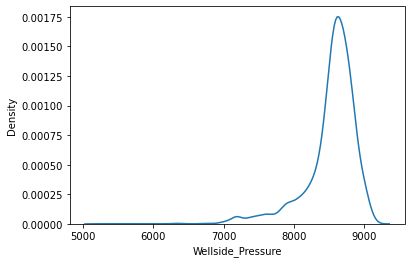

In [6]:
sns.kdeplot(df['Wellside_Pressure']);

### Wellside Pressure BoxPlot
From the boxplot it is evident that we got outliers which we will strip out. It will be good not to strip too much, on safe side we can ignore the value less than 7000.

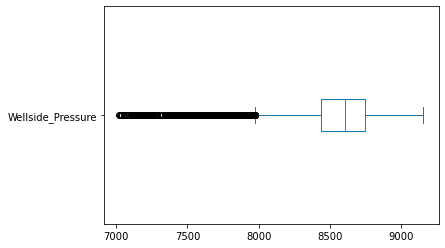

In [132]:
df['Wellside_Pressure'].plot(kind='box', vert=False);

#### Cleaning outliers


In [8]:
df=df[df['Wellside_Pressure']>7000]

Look at the boxplot again

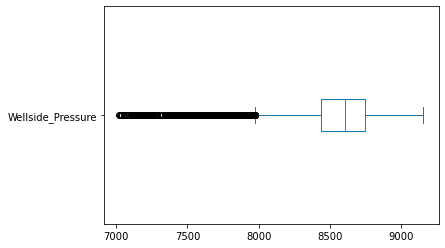

In [9]:
df['Wellside_Pressure'].plot(kind='box', vert=False);

We may also take a look at the wellside pressure of all 5 wells individually.

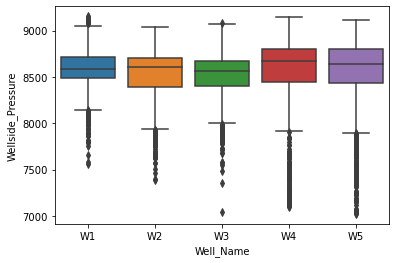

In [133]:
sns.boxplot(df, x=df['Well_Name'], y=df['Wellside_Pressure']);

### Wellside Pressure Series
Series seems to be stationary but this will be confirmed later.

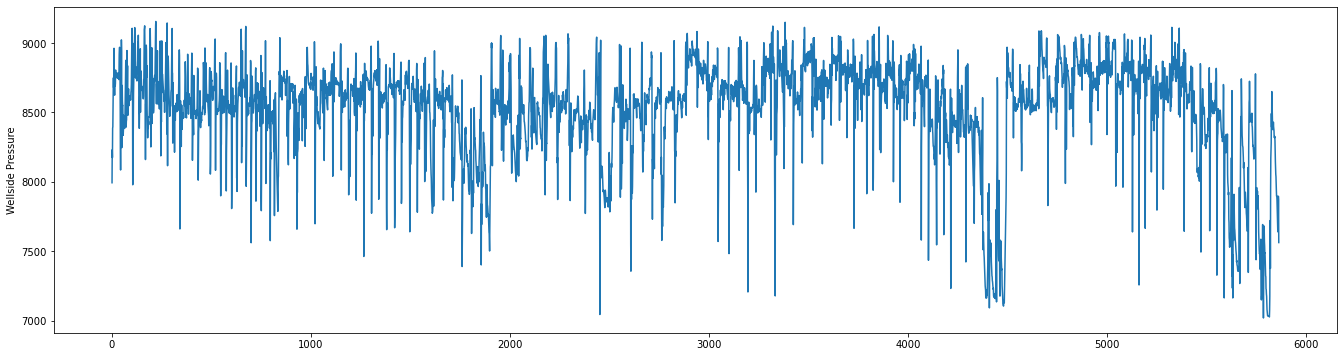

In [11]:
plt.figure(figsize=(23,6))
plt.plot(df['Wellside_Pressure'])
plt.ylabel('Wellside Pressure');

## Time series Stationarity
A time series has stationarity when the observations are not dependent on the time. Statistical properties of these time series will not change with time thus they will have constant mean, variance, and covariance.
We can perform Augmented Dickey-Fuller test to check the stationarity.

#### Augmented Dickey-Fuller(ADF) test
Augmented Dickey-Fuller (ADF) test is a statistical test that belongs to the unit root test which tests the null hypothesis.The unit root is a characteristic of a time series which makes it non-stationary. A linear stochastic process has a unit root if 1 is a root of the process’s characteristic equation. Such a process is non-stationary but does not always have a trend.

In [13]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Wellside_Pressure'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.24064889133134
p-value: 7.2586417183842685e-06
Critial Values:
   1%, -3.4314773815268933
Critial Values:
   5%, -2.862038195900677
Critial Values:
   10%, -2.5670351876718884


As the **test value** is lower than other **critical values** and **p-value** is lower than the significance level of 0.05, so we reject the Null-hypothesis that unit root is present. This implies that this series is **stationary**.

## AutoCorrelation
Autocorrelation is the measure of the degree of similarity between a given time series and the lagged version of that time series over successive time periods. It shows wether there is any correlation between given time and  previous time if there is any then we got some predictive power for forcasting.

### AutoCorrelation plot (ACF)
ACF plot using 50 lags.

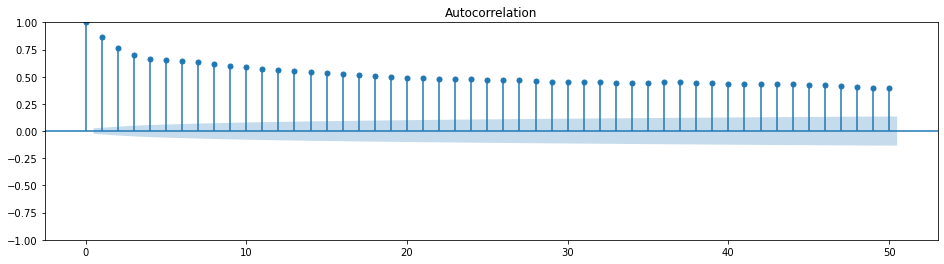

In [23]:
f,ax=plt.subplots(figsize=(16,4))
plot_acf(df['Wellside_Pressure'], lags=50, ax=ax);

### Partial AutoCorrelation (PACF)
A partial autocorrelation, on the other hand, is a description of the relationship between an observation in a time series and data from earlier time steps that do not take into account the correlations between the intervening observations. The correlation between observations at successive time steps is a linear function of the indirect correlations. These indirect connections are eliminated using the partial autocorrelation function.

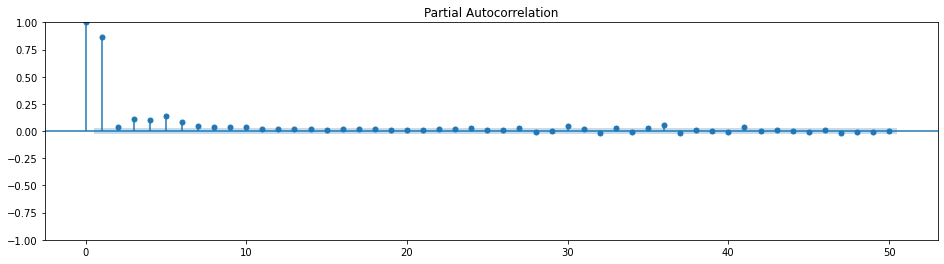

In [24]:
f,ax=plt.subplots(figsize=(16,4))
plot_pacf(df['Wellside_Pressure'], lags=50, ax=ax);

This implies that upto 7 lags provide prediction power for forcasting.

### Correlation with Lag of 1
Let's visualize the correlation between values and their lag of 1,

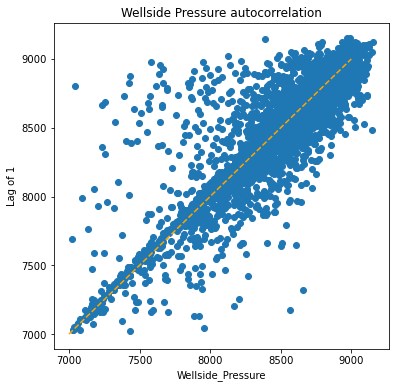

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df['Wellside_Pressure'], y=df['Wellside_Pressure'].shift(1))
ax.plot([7000,9000],[7000,9000], ls='--',c='orange')
plt.xlabel('Wellside_Pressure')
plt.ylabel('Lag of 1')
plt.title('Wellside Pressure autocorrelation');

We can see a strong correlation here which we can determine quantitively using pearson correlation.

In [27]:
df['Wellside_Pressure'].corr(df['Wellside_Pressure'].shift(1))

0.8701452806108577

The value is close to 1 which shows a that there is very strong correlation.

## Model Building

To build a model for trainging and forcastion, firstly we have to split the data for training and testing/forcasting. In time series we can not choose the data randomly as we have to predict the future based on the past values. So here we split the that such that the Wellside Pressure of first 4 wells will be out training data and that of well 5, we will predict.

In [39]:
cutoff=len(df[df['Well_Name']!='W5'])
y_train=df['Wellside_Pressure'].reset_index(drop=True)[:cutoff]
y_test=df['Wellside_Pressure'].reset_index(drop=True)[cutoff:]

### Baseline Model
We develop a baseline model which will be our comparision for our Model performance. This baseline model is the mean of the data.

In [30]:
y_pred_baseline=[y_train.mean()]*len(y_train)
mae_baseline=mean_absolute_error(y_train, y_pred_baseline)

print('Mean Wellside Pressure reading:', round(y_train.mean(),2))
print('Baseline MAE:', round(mae_baseline,2))

Mean Wellside Pressure reading: 8536.67
Baseline MAE: 226.38


So we have MAE score of 226.38 which out model should have to beat.

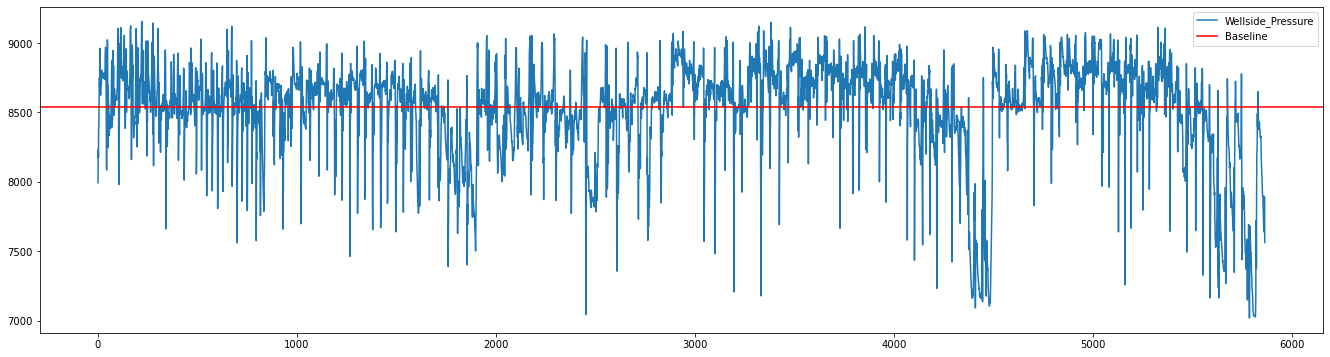

In [35]:
f,ax=plt.subplots(figsize=(23,6))
ax.plot(df['Wellside_Pressure'])
ax.axhline(y_train.mean(), c='red')
ax.legend(['Wellside_Pressure', 'Baseline']);

### AutoReg Model
Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.
#### Walk Forward Validation
Predictions over time tend to become error prone in the case of time-series modeling; thus a realistic approach would be to re-train the model with actual data as and when available for future predictions and validate simultaneously. So walk-forward validation is the most preferred solution to get most accurate results.

In [40]:
# AutoReg model with walk-forward validation

#initializing prediction series to save predictions
y_pred_wfv=pd.Series()
#history to train for forcasting
history=y_train.copy()

for i in range(len(y_test)):
    #Model training with lag of 7
    model=AutoReg(history, lags=7).fit()
    #Forcasting the next value
    next_pred=model.forecast()
    #Appending the predicted value
    y_pred_wfv=y_pred_wfv.append(next_pred)
    #Appending history for next frocasting
    history=history.append(y_test[next_pred.index])

test_mae=mean_absolute_error(y_test, y_pred_wfv)
print('Test MAE walk forward validation:', round(test_mae,2))

Test MAE walk forward validation: 98.14


Mean absolute error is well below the baseline so our model did pretty well.

Let's take a look at the visualization.

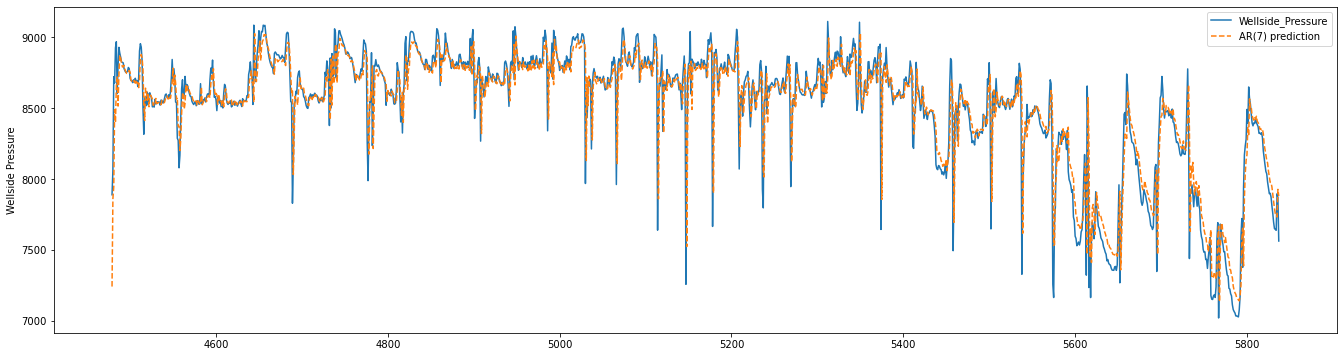

In [42]:
f,ax=plt.subplots(figsize=(23,6))
ax.plot(y_test)
ax.plot(y_pred_wfv, '--')
ax.set_ylabel('Wellside Pressure')
ax.legend(['Wellside_Pressure', 'AR(7) prediction']);

## Random Forest Model
Random Forest is a popular and effective ensemble machine learning algorithm.

It is widely used for classification and regression predictive modeling problems with structured (tabular) data sets, e.g. data as it looks in a spreadsheet or database table.

Random Forest can also be used for time series forecasting, although it requires that the time series dataset be transformed into a supervised learning problem first. It also requires the use walk-forward validation for evaluating, as evaluating the model using k-fold cross validation would result in optimistically biased results

MAE: 100.537


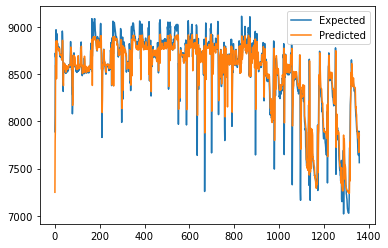

In [54]:
# Random Forest model with walk-forward validation

# ----------------Functions----------------#
#Time series data tranformation into supervised learning dataset for RF model
def series_to_supervised(data, n_in=1, n_out=1):
    n_vars = 1
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # concatinate all
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=50, max_depth=20, max_leaf_nodes=20)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    # retuen one-step prediction
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = list(train.copy())
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])

    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# target values
values = df['Wellside_Pressure'].to_list()
# number of test features
n_test=len(df[df['Well_Name']=='W5'])
# transform the time series data into supervised learning with lag of 7
data = series_to_supervised(values, n_in=7)
# evaluate
mae, y, yhat = walk_forward_validation(data, n_test)
print('MAE: %.3f' % mae)
# plot expected vs predicted
plt.figure(figsize=(16,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted','--')
plt.legend()
plt.show()

Random Forest Model also perform well beating the baseline

## LSTM
LSTM stands for long short term memory. It is a model or architecture that extends the memory of recurrent neural networks. Typically, recurrent neural networks have ‘short term memory’ in that they use persistent previous information to be used in the current neural network. Essentially, the previous information is used in the present task. That means we do not have a list of all of the previous information available for the neural node.

LSTM can be used for time series forcasting by converting time series to supervised learning dataset.

(5831, 8)
(4479, 7) 4479 (4479,)
(4479, 7, 1) (4479,) (1352, 7, 1) (1352,)
Epoch 1/50
63/63 - 5s - loss: 0.1890 - val_loss: 0.0819 - 5s/epoch - 85ms/step
Epoch 2/50
63/63 - 1s - loss: 0.0677 - val_loss: 0.0978 - 722ms/epoch - 11ms/step
Epoch 3/50
63/63 - 1s - loss: 0.0692 - val_loss: 0.1016 - 716ms/epoch - 11ms/step
Epoch 4/50
63/63 - 1s - loss: 0.0689 - val_loss: 0.0975 - 702ms/epoch - 11ms/step
Epoch 5/50
63/63 - 1s - loss: 0.0677 - val_loss: 0.0922 - 716ms/epoch - 11ms/step
Epoch 6/50
63/63 - 1s - loss: 0.0663 - val_loss: 0.0893 - 717ms/epoch - 11ms/step
Epoch 7/50
63/63 - 1s - loss: 0.0651 - val_loss: 0.0885 - 732ms/epoch - 12ms/step
Epoch 8/50
63/63 - 1s - loss: 0.0644 - val_loss: 0.0864 - 703ms/epoch - 11ms/step
Epoch 9/50
63/63 - 1s - loss: 0.0635 - val_loss: 0.0839 - 719ms/epoch - 11ms/step
Epoch 10/50
63/63 - 1s - loss: 0.0625 - val_loss: 0.0828 - 927ms/epoch - 15ms/step
Epoch 11/50
63/63 - 1s - loss: 0.0619 - val_loss: 0.0819 - 909ms/epoch - 14ms/step
Epoch 12/50
63/63 - 1s -

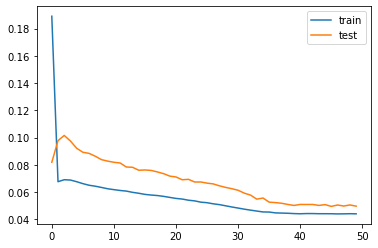

43/43 [==============================] - 1s 5ms/step
Test MAE: 101.320


In [130]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
#dataset = df.drop(columns=['Well_Name', 'Well_Stage', 'Time'])
dataset=df['Wellside_Pressure'].to_numpy().reshape(-1, 1)
values = dataset

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_lag = 7
n_features = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train = len(df[df['Well_Name']!='W5'])
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
n_obs = n_lag * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_lag*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -31:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -31:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate MSE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

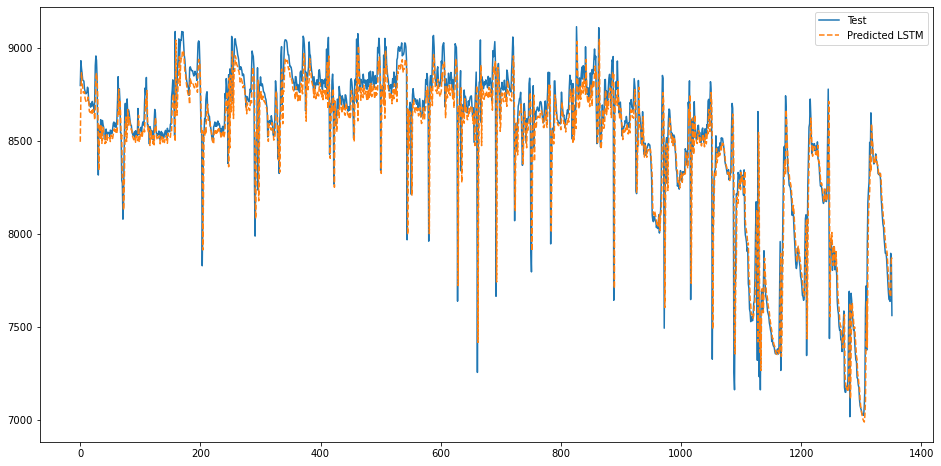

In [131]:
plt.figure(figsize=(16,8))
plt.plot(inv_y)
plt.plot(inv_yhat,'--')
plt.legend(['Test','Predicted LSTM']);

LSTM also performed very well even with just two layers the results seems to be reasobably good.